# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [12]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "Playlist Duration", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df

,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,Local,Genre,Label,UPC
0,Our Intent is All for Your Delight,64617,Dan Kirk,"Sep 23, 2019",8:04:12 AM,Khruangbin,People Everywhere (Still Alive),The Universe Smiles Upon You,NaN,NaN,Rock,Night Time Stories,4523132552217.0
1,Our Intent is All for Your Delight,64617,Dan Kirk,"Sep 23, 2019",8:07:21 AM,The Bubs,Golden Thread,Golden Thread,NaN,NaN,Rock,The Bubs,859732310242.0
2,Our Intent is All for Your Delight,64617,Dan Kirk,"Sep 23, 2019",8:11:38 AM,Y La Bamba,Rios Sueltos,Entre Los Dos,N,NaN,Rock,Tender Loving Empire,703669152959.0
3,Our Intent is All for Your Delight,64617,Dan Kirk,"Sep 23, 2019",8:15:42 AM,Allah-Las,Prazer Em Te Conhecer,LAHS,NaN,NaN,Rock,Mexican Summer,184923126068.0
4,Our Intent is All for Your Delight,64617,Dan Kirk,"Sep 23, 2019",8:20:57 AM,Devendra Banhart,My Boyfriend's in the Band,Ma,NaN,NaN,Rock,Nonesuch,75597924053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284735,Long Distance Runner,160029,DJ Squared,"Mar 22, 2024",4:05:08 PM,Bill Laswell,Buhala,Means of Deliverance,NaN,NaN,Jazz,Innerhythmic,0804699102423
284736,Long Distance Runner,160029,DJ Squared,"Mar 22, 2024",4:08:25 PM,Remy Le Boeuf,Little Song,Heartland Radio,NaN,NaN,Jazz,ORCHARD - SoundSpore Records,0197190669947
284737,Long Distance Runner,160029,DJ Squared,"Mar 22, 2024",4:14:10 PM,strongboi,fool around,fool around,NaN,NaN,NaN,strongboi,5059449065564
284738,Long Distance Runner,160029,DJ Squared,"Mar 22, 2024",4:18:52 PM,Miya Folick,Bad Thing,Bad Thing,NaN,NaN,NaN,Nettwerk Music Group,0067003373463


In [13]:
# Count null values
df.isna().sum()


Playlist Title         0
DJ ID                  0
DJ Name                0
Date                   0
Time                   0
Artist                 4
Song                   2
Release               50
New               252062
Local             281156
Genre              97305
Label               1137
UPC                28232
dtype: int64

In [14]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


Playlist Title        0
DJ ID                 0
DJ Name               0
Date                  0
Time                  0
Artist                0
Song                  0
Release               0
New                   0
Local                 0
Genre             97305
Label              1095
UPC               28182
dtype: int64

#### Additional Collection: Genre and Billboard Hot 100 Policy Violations

In [16]:
# function to scrape billboard site given artist name 
def web_scrape_bb(artist_name):
    # convert artist name to - if spaces
    artist_name = artist_name.lower()
    artist_name = artist_name.replace(' ', '-')
    base = 'https://www.billboard.com/artist/'
    url = base + artist_name
    # need to add in try/excepts for if the artist is too obscure to have a billboard page 
    page = requests.get(url)
    if page.reason == "Not Found":
        return 0
    else:
        soup = BeautifulSoup(page.content, "html.parser")
        num2 = soup.find_all("div", class_="lrv-u-background-color-brand-accent-yellow lrv-u-height-100p lrv-u-flex lrv-u-flex-direction-column lrv-u-justify-content-center lrv-u-align-items-center u-padding-tb-075" )
        results = soup.find_all("span", class_="c-span a-font-primary-bold u-font-size-34 u-line-height-120 u-letter-spacing-0063 artist-stat-3")
        if len(results) < 1: 
            return 0 
        #print(results[0].text)
        hits = results[0].text.strip()
    
    
        # if statement below is an attempt to get the songs that have been on the billboard top 100 (to see if there is a direct policy violation)
        # unfortunately, these tables are populated with javascript and difficult to scrape 
        #if hits != '0':
        #    url = url + "/chart-history/hsi"
        #    page = requests.get(url)
        #    soup = BeautifulSoup(page.content, "html.parser")
        #    songs = soup.find_all()
        
        # NOTE: currently coded to write flag or has or has not charted by artist not song 
        if hits > 1:
            return 1
        return 0


'''
hits = []

for i in range(len(df)):
    hits.append(web_scrape_bb(df['Artist'].loc[i]))
df['billboards hits'] = hits
df
'''
    

"\nhits = []\n\nfor i in range(len(df)):\n    hits.append(web_scrape_bb(df['Artist'].loc[i]))\ndf['billboards hits'] = hits\ndf\n"

In [17]:
# global variable for valid genres in spinitron 
GENRES = df['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp

def get_genre_by_artist(sp, artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    # make sure that the result is for the artist we want
    result_name = results['artists']['items'][0]['name']
    i = 0
    while (result_name != artist_name) & (i < 10):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']

        print(f'{artist_name} is associated with {genres}')
        for genre in genres:
            if genre in GENRES:
                #print(f'solution = {genre}')
                return genre 
    return 'NA'

# next step: instead of returning result_string, return dictionary of values OR empty dictionary of NAs?
def spotify_search_song(sp, artist_name, song_name):
    # when i search california, it gives me teenage dream by katy Perry so not sure how well this works
    results = sp.search(q='track:' + song_name, type='track', limit=10)
    results_title = results['tracks']['items'][0]['name']
    results_album = results['tracks']['items'][0]['album']['name']
    results_artist = results['tracks']['items'][0]['artists'][0]['name']
    # then if this results title matches our song name and the artist matches our artist, find the audio features and add them (by spotify uri id for song)
    i = 0
    while (results_artist != artist_name) & (results_title != song_name) & (i < 10):
        results_title = results['tracks']['items'][i]['name']
        results_artist = results['tracks']['items'][i]['artists'][0]['name']
        i += 1
    if (results_artist == artist_name) & (results_title == song_name):
        uri = results['tracks']['items'][i]['id'] 
        # these are audio features!! like danceability, energy, key, loudness..
        # stored in an array of length 1 containing a dictionary (key = audio feature, value = value of that feature)
        features = sp.audio_features(uri)
        result_string =  f'TOP RESULT: {results_title} from {results_album} by {results_artist}. URI: {uri}'
        return result_string
    result_string = f'the search for {song_name} by {artist_name} was not found'
    return result_string
    
token = spotify_connect()
# note: Radiohead was in the example online, I did not think oh yes, Radiohead lol
print(get_genre_by_artist(token, 'Radiohead'))
print(spotify_search_song(token, 'Joni Mitchell', 'California'))

Radiohead is associated with ['alternative rock', 'art rock', 'melancholia', 'oxford indie', 'permanent wave', 'rock']
rock
the search for California by Joni Mitchell was not found


In [18]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

#df["Genre"].fillna(get_genre_by_artist(token, df["Artist"]))

# working on using the functions already written to fill missing values but not working yet

'''
for r in range(len(df)):
    if df.loc[r]["Genre"] == "nan":
        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])
        print(df.loc[r]["Artist"], df.loc[r]["Genre"])
print('done')
print(df["Genre"].isna().sum())
'''




51782
count     139217
unique        20
top         Rock
freq       55573
Name: Genre, dtype: object


'\nfor r in range(len(df)):\n    if df.loc[r]["Genre"] == "nan":\n        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])\n        print(df.loc[r]["Artist"], df.loc[r]["Genre"])\nprint(\'done\')\nprint(df["Genre"].isna().sum())\n'

#### Data Wrangling and Visualization

<BarContainer object of 20 artists>

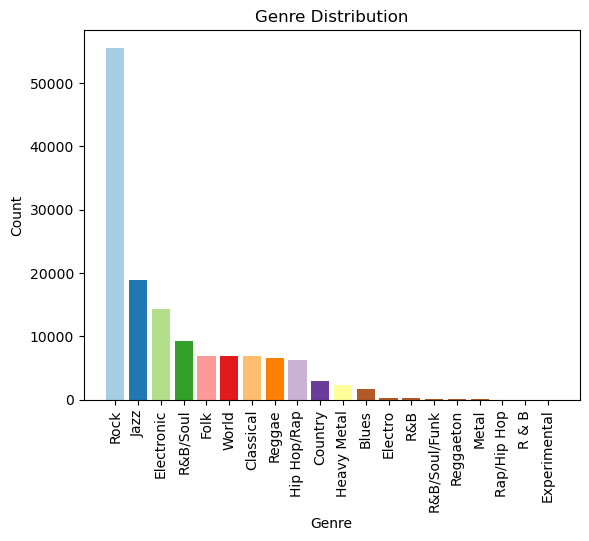

In [19]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

# TODO: Combine genres


<Axes: >

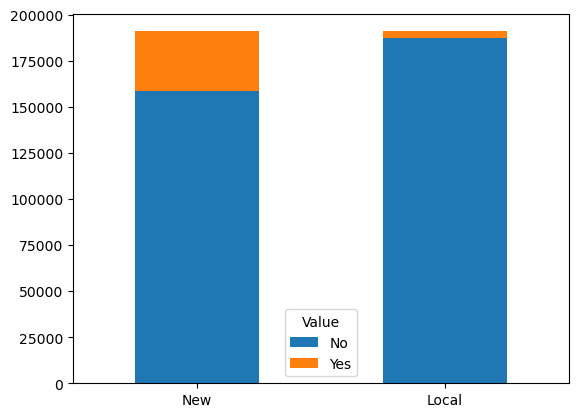

In [39]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [ ]:
def spins_to_shows(df):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe of shows
    """
    


df = spins_to_shows(df)

## Data Modeling

#### Policy Violation Linear Regression

#### DJ Clustering